# OSMO Staking

## Introduction
Osmosis is a specialized blockchain built to run advanced Automated Market Maker (AMM) functions and execute cross-chain transactions by utilizing the Inter-Blockchain Communication (IBC) protocol. The blockchain is ever-expanded by validators who need to stake OSMO, the native coin of the network, and governed by its delegators.

In this report we will have a closer look at the staking activity over time and try to uncover how much of the OSMO supply is being staked.

## Obtaining and Understanding the Data
The **staking** and **unstaking** actions naturally take place and are recorded on the blockchain and we will use the neatly curated tables of FlipsideCrypto to find these transactions. In the transaction logs, these actions are refered to as `delegate` and `unbond` and they carry with them information such as the date, delegator, validator, as well as the token amount.

**Note: Users have a third option to redelegate their tokens, but since that does not change the amount staked, they will not be part of the analysis.*

The OSMO token is denominated on the blockchain as `uosmo` and in raw format is not adjusted to its 6 decimals so we will do that ourselves after obtaining the data.

The following query was used to obtain the data which was then exported through a JSON API and imported in this notebook as a Pandas DataFrame:
```sql
with

staking as (
  select
    block_timestamp,
    regexp_replace(try_base64_decode_string(f.value:"value"::string),'uosmo','')::int / pow(10,6) as osmo,
    'STAKE' as label_action
  from osmosis.core.fact_msgs txs
  inner join lateral flatten(input => msg:attributes) f
  where f.value:"key"::string = 'YW1vdW50' -- 'amount' decoded
    and msg_type = 'delegate'
    and block_timestamp >= '2021-06-01'
    and tx_status = 'SUCCEEDED'
),

unstaking as (
  select
    block_timestamp,
    regexp_replace(try_base64_decode_string(f.value:"value"::string),'uosmo','')::int / pow(10,6) as osmo,
    'UNSTAKE' as label_action
  from osmosis.core.fact_msgs txs
  inner join lateral flatten(input => msg:attributes) f
  where f.value:"key"::string = 'YW1vdW50' -- 'amount' decoded
    and msg_type = 'unbond'
    and block_timestamp >= '2021-06-01'
    and tx_status = 'SUCCEEDED'
),

aggregated as (
  select
    block_timestamp::date as date,
    label_action,
    sum(osmo) as osmo
  from (select * from staking union all select * from unstaking)
  group by 1,2
)

select
    *
from aggregated
```

In [15]:
import pandas as pd

flip_results = 'https://node-api.flipsidecrypto.com/api/v2/queries/eb582ce9-3ade-46fe-b1d4-610c39ab82eb/data/latest'

df_flip = pd.read_json(flip_results)\
    .sort_values(by='DATE', ascending=True)\
    .reset_index(drop=True)
df_flip.columns = df_flip.columns.str.lower()

df_flip.head()

,date,label_action,osmo
0,2021-06-18,STAKE,3.421960e+03
1,2021-06-19,UNSTAKE,1.463607e+04
2,2021-06-19,STAKE,1.368507e+06
3,2021-06-20,STAKE,2.037103e+06
4,2021-06-20,UNSTAKE,4.494845e+04


Other than the staking data, we need the circulating amount of OSMO. In this case, the **current** circulating supply can be queried from many sources such as the [OSMOSIS LCD](https://lcd-osmosis.blockapsis.com/swagger/) or others listed in the [docs](http://docs.osmosis.zone/). However, none of these offer a **historical** record of the circulating supply, so we will have to go about it a different way.

By observing the OSMO Market Cap reported by the recommended Osmosis Explorers, it turns out that the MC is the result of the circulating supply reported through the previously mentioned multiplied by the current OSMO price. Therefore, we can reverse-engineer the historical circulating suply using the historical Market Cap and Price of OSMO.

Through the [CoinGecko API](https://www.coingecko.com/en/api/documentation) we can obtain the daily average price and Market Cap which can be queried directly in this notebook and turned into a Pandas DataFrame for further transformation. Even this source however has a limited record of OSMO MC, going only as far back as **July 8, 2022**.

In [2]:
from datetime import date, timedelta
# The code below creates a list of dates in the format required by the CoinGecko API
start = '2021-06-01'
end = str(date.today())
start_date = date.fromisoformat(start)
end_date = date.fromisoformat(end)

date_range = [
    (end_date - timedelta(days=i)).strftime('%d-%m-%Y')
    for i
    in range((end_date - start_date).days)
]

In [4]:
# CoinGecko API import
from pycoingecko import CoinGeckoAPI
cg = CoinGeckoAPI()
# Dictionary containing only the relevant data from the query response
cgk_mk_data = {
    'date':[],
    'price':[],
    'mc':[],
    'circ_supply':[]
}

import time
# API loop for each date
for date in date_range:
    cgk_mk_data['date'].append(date)

    try:
        response_data = cg.get_coin_history_by_id(id='osmosis', date=date, localization=False)['market_data']
        cgk_mk_data['price'].append(response_data['current_price']['usd'])
        cgk_mk_data['mc'].append(response_data['market_cap']['usd'])
        cgk_mk_data['circ_supply'].append(response_data['market_cap']['usd'] / response_data['current_price']['usd'])
    except:
        cgk_mk_data['price'].append(None)
        cgk_mk_data['mc'].append(None)
        cgk_mk_data['circ_supply'].append(None)

    time.sleep(1.5)

In [5]:
df_cgk = pd.DataFrame(data=cgk_mk_data)\
    .dropna(axis=0, how='any')
df_cgk = df_cgk[df_cgk.mc > 0]
df_cgk.date = pd.to_datetime(df_cgk.date, format='%d-%m-%Y')
df_cgk.sort_values(by='date', ascending=True, inplace=True)
df_cgk.head()

,date,price,mc,circ_supply
325,2021-07-08,2.915541,3.355235e+08,1.150810e+08
324,2021-07-09,2.443652,2.797811e+08,1.144930e+08
323,2021-07-10,2.270988,2.644301e+08,1.164384e+08
322,2021-07-11,2.380778,2.802538e+08,1.177152e+08
321,2021-07-12,2.305737,2.722665e+08,1.180822e+08


After both datasets have been successfully imported, we can merge them together in the `df_cumulative` DataFrame below. The daily `staked amount` is represented by the difference between the daily staked and unstaked tokens.

In the same df we can apply several transformations to obtain a `rolling sum` of the OSMO being staked over `30`,`60`,`90` days, as well as an all-time cumulative sum of the staked OSMO.

In [16]:
df_cumulative = df_flip[['date','label_action','osmo']]\
    .pivot(index='date',columns='label_action',values='osmo')\
    .reset_index()
df_cumulative.fillna(0, inplace=True)
df_cumulative.columns = df_cumulative.columns.str.lower()
df_cumulative['staked_amount'] = df_cumulative.stake - df_cumulative.unstake

df_cumulative['rolling_30'] = df_cumulative.staked_amount.rolling(30).sum()
df_cumulative['rolling_60'] = df_cumulative.staked_amount.rolling(60).sum()
df_cumulative['rolling_90'] = df_cumulative.staked_amount.rolling(90).sum()
df_cumulative['cumulative'] = df_cumulative.staked_amount.cumsum()

df_cumulative = df_cumulative.merge(right=df_cgk, on='date', how='left')\
    .reset_index(drop=True)

df_cumulative['staking_ratio'] = df_cumulative.cumulative / df_cumulative.circ_supply * 100

df_cumulative.head()

,date,stake,unstake,staked_amount,rolling_30,rolling_60,rolling_90,cumulative,price,mc,circ_supply,staking_ratio
0,2021-06-18,3.421960e+03,0.000000,3.421960e+03,NaN,NaN,NaN,3.421960e+03,NaN,NaN,NaN,NaN
1,2021-06-19,1.368507e+06,14636.070020,1.353871e+06,NaN,NaN,NaN,1.357293e+06,NaN,NaN,NaN,NaN
2,2021-06-20,2.037103e+06,44948.452141,1.992154e+06,NaN,NaN,NaN,3.349447e+06,NaN,NaN,NaN,NaN
3,2021-06-21,1.666067e+06,24445.056033,1.641622e+06,NaN,NaN,NaN,4.991068e+06,NaN,NaN,NaN,NaN
4,2021-06-22,2.425673e+06,12517.170998,2.413156e+06,NaN,NaN,NaN,7.404224e+06,NaN,NaN,NaN,NaN


For the last metric we are interested in, a `rolling average` of staked OSMO, we are going to create a new DataFrame that we can reference more easily later on.

In [17]:
df_rolavg = df_flip[['date','label_action','osmo']].pivot(index='date',columns='label_action',values='osmo')\
    .reset_index()
df_rolavg.fillna(0, inplace=True)
df_rolavg.columns = df_rolavg.columns.str.lower()
df_rolavg.columns.name = ''
df_rolavg['staked_amount'] = df_rolavg.stake - df_rolavg.unstake

df_rolavg['rolling_30'] = df_rolavg.staked_amount.rolling(30).mean()
df_rolavg['rolling_60'] = df_rolavg.staked_amount.rolling(60).mean()
df_rolavg['rolling_90'] = df_rolavg.staked_amount.rolling(90).mean()

df_rolavg.head()

,date,stake,unstake,staked_amount,rolling_30,rolling_60,rolling_90
0,2021-06-18,3.421960e+03,0.000000,3.421960e+03,NaN,NaN,NaN
1,2021-06-19,1.368507e+06,14636.070020,1.353871e+06,NaN,NaN,NaN
2,2021-06-20,2.037103e+06,44948.452141,1.992154e+06,NaN,NaN,NaN
3,2021-06-21,1.666067e+06,24445.056033,1.641622e+06,NaN,NaN,NaN
4,2021-06-22,2.425673e+06,12517.170998,2.413156e+06,NaN,NaN,NaN


In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style('darkgrid')

## Results

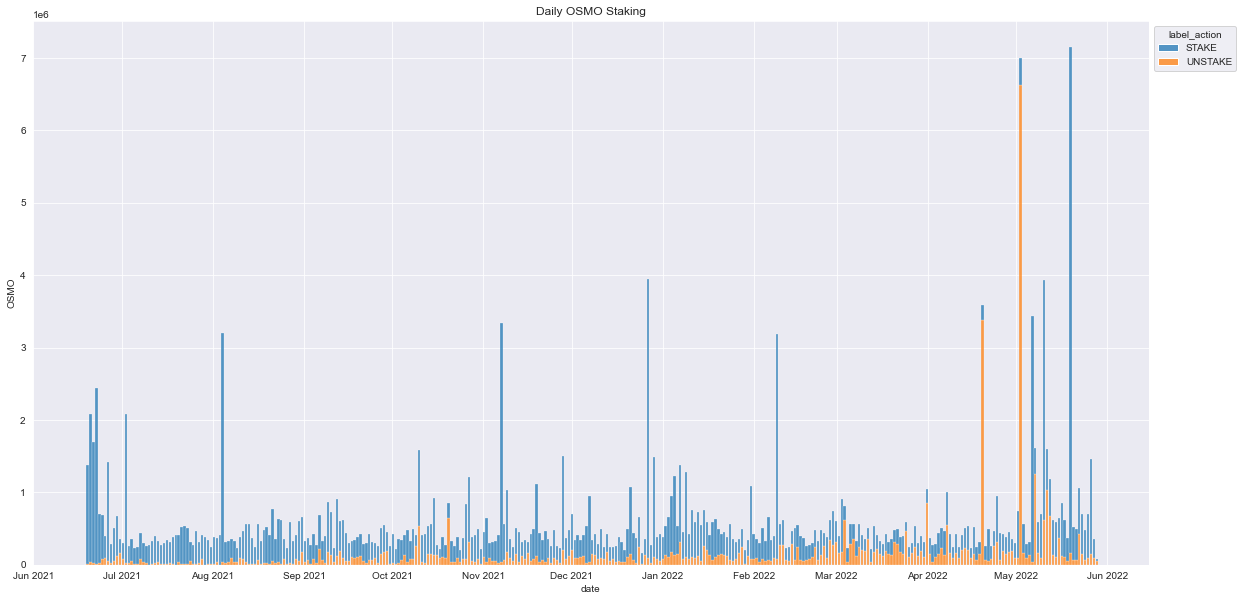

In [18]:
plt.figure(figsize=(20,10))
nbins = df_flip.date.nunique()
ax = sns.histplot(df_flip, x='date', hue='label_action', weights='osmo',
             multiple='stack', shrink=0.8, bins=nbins)
ax.set_ylabel('OSMO')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.title('Daily OSMO Staking', loc='center')

legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 1))

The staking of OSMO started back in `June 06, 2021` and as we can see below it's been a period with a lot of staking activity. From that point on, daily stakes have remained in the same range under 0.5M OSMO but with occasional periods of increased activity where we can see 3M, 4M or as much as 6.9M OSMO staked in a single day. 

This record staking day was on `May 20, 2022` indicating that over this entire period, the Osmosis network was able to build more trust and encourage more participation. It is even more significant that this happened right after a turbulent week for the crypto market started by the collapse of the similarly built Terra blockchain that Osmosis was connected with.

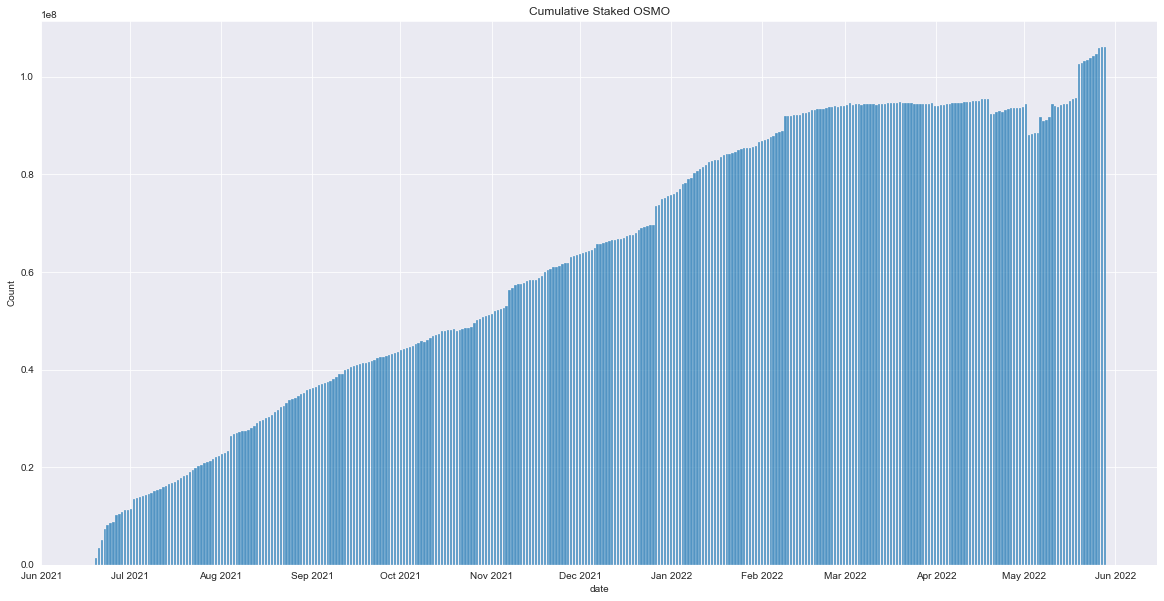

In [19]:
plt.figure(figsize=(20,10))
nbins = df_cumulative.date.nunique()
ax = plt.subplot()
sns.histplot(df_cumulative, x='date', weights='cumulative', shrink=0.8, bins=nbins)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.title('Cumulative Staked OSMO')

plt.show()

In the graph above we can see the cumulative amount of OSMO staked over time.

It had a consistent growth for most of the time, but March through May 2022 has been a period of stagnation. Right after, the events of the May 08-14 week put a significant dent in the stake of the network but it quickly recovered and resumed its upward trend with more OSMO staked than ever.

Currently there are more than **105M OSMO** staked on the Osmosis network.

Next up, the rolling sum of daily staked OSMO.

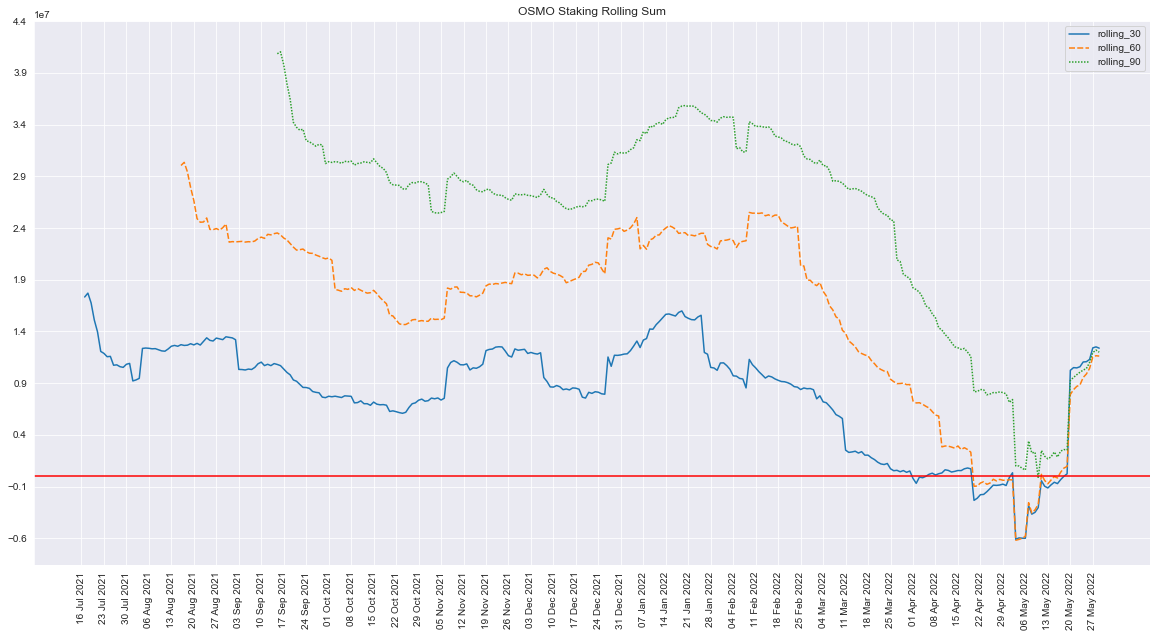

In [31]:
plt.figure(figsize=(20,10))

ax = plt.subplot()

sns.lineplot(data=df_cumulative[['date','rolling_30','rolling_60','rolling_90']])
plt.axhline(0, color='red')
plt.title('OSMO Staking Rolling Sum')

plt.xticks(range(28,346,7), rotation=90)
ax.set_xticklabels([df_cumulative.date[x].strftime('%d %b %Y') for x in range(28,344,7)])

plt.yticks(range(-6000000,45000000,5000000))

plt.show()


Once again, we can see the staking amount taking a severe hit in late April and early May. In the case of the rolling 30 and 60 day sum, the staking amount turns negative, going as low as -6M OSMO. The values return to positive teritory on May 20 after a massive amount of OSMO staked on the date.

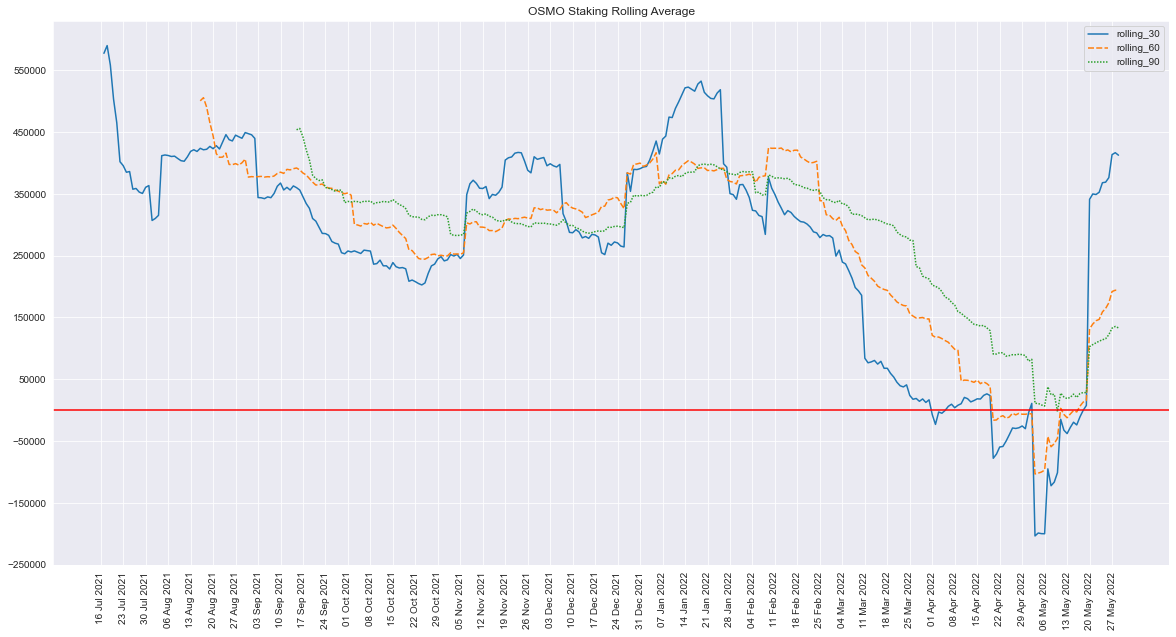

In [32]:
plt.figure(figsize=(20,10))

ax = plt.subplot()

sns.lineplot(data=df_rolavg[['date','rolling_30','rolling_60','rolling_90']])
plt.axhline(0, color='red')
plt.title('OSMO Staking Rolling Average')

plt.xticks(range(28,346,7), rotation=90)
ax.set_xticklabels([df_cumulative.date[x].strftime('%d %b %Y') for x in range(28,344,7)])
plt.yticks(range(-250000,650000,100000))

plt.show()

The rolling average of the daily OSMO staked reveals that the downward trend has formed even earlier, in the first half of Fabruary. After a steep decline in staked OSMO over the following weeks, the 30 days rolling average has a negative value on April 01.

The downward trend has been reversed on May 20.

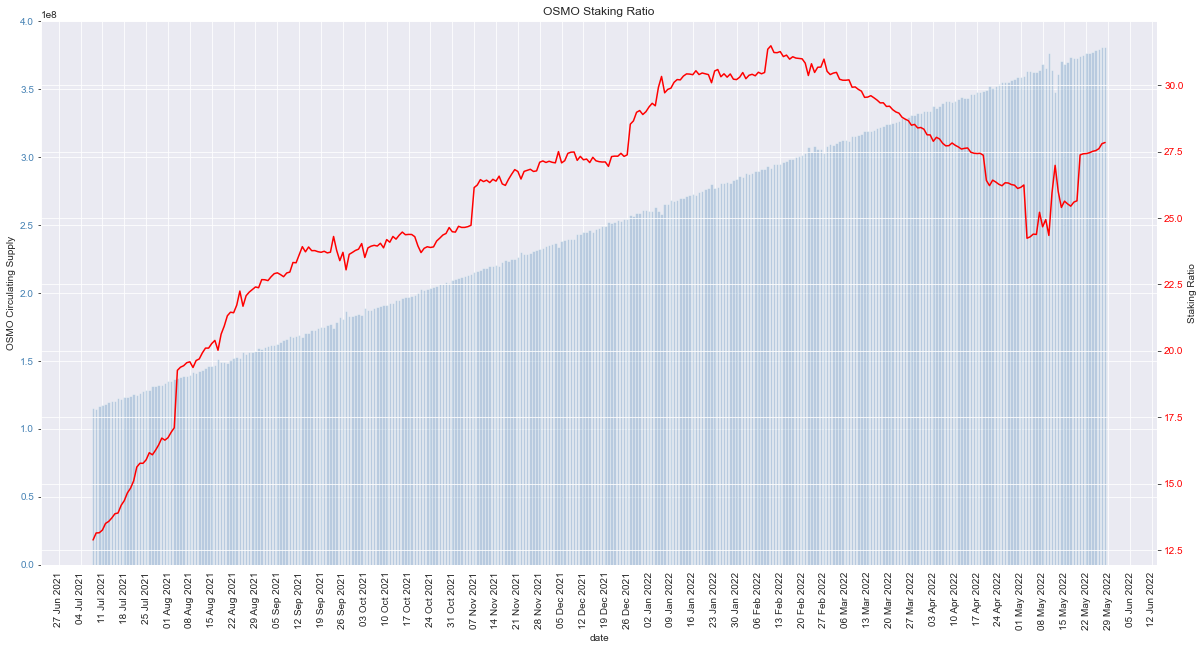

In [39]:
df_sliced = df_cumulative[(df_cumulative.date >= '2021-07-08') & (df_cumulative.date < '2022-05-29')]

cumulative = df_sliced.cumulative
circulating = df_sliced.circ_supply
staking_ratio = df_sliced.staking_ratio
d = df_sliced.date

def two_scales(ax1, date, data1, data2, c1, c2):

    ax2 = ax1.twinx()

    ax1.bar(date, data1, color=c1, alpha=0.3)
    ax1.set_xlabel('date')
    ax1.set_ylabel('OSMO Circulating Supply')

    ax2.plot(date, data2, color=c2)
    ax2.set_ylabel('Staking Ratio')
    return ax1, ax2

fig, ax = plt.subplots(figsize=(20,10))
plt.xticks(rotation=90)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))

ax1, ax2 = two_scales(ax, d, circulating, staking_ratio, 'steelblue', 'r')
plt.title('OSMO Staking Ratio')

def color_y_axis(ax, color):
    for t in ax.get_yticklabels():
        t.set_color(color)
    return None

color_y_axis(ax1, 'steelblue')
color_y_axis(ax2, 'r')

plt.show()

The staking ratio we can calculate using the available data starts on July 08, 2021. On that date, 12.87% of the OSMO circulating supply had been staked. it continues to grow over the following months and culminates on February 10, 2022 at 31.49%. This date also marks the start of a gradual decrease in the staking ratio that lasts until May 03 when it bottoms at 24.24%.

The staking ratio currently sits at 27.84% of the circulating supply.

## tl;dr
- Daily OSMO staking amounts have remained constant for most of the time but have also had occasional periods of large staking days with as much as 6.9M OSMO.
- Over 105M OSMO have been staked so far.
- From February to May, staking stagnated and even registered negative rolling sum and average values. However, the trend has reversed after a period of increased staking amounts after May 11.
- The staked OSMO represents 27.8% of the circulating supply.